In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import statsmodels.stats.api as sms 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
effect_size=sms.proportion_effectsize(0.13,0.15) # 根据预期比率计算效果量，0.13就是旧版转化率，0.15是新版转化率
effect_size

-0.0576728617308947

计算所需最小样本量

In [4]:
require_n=sms.NormalIndPower().solve_power(effect_size,alpha=0.05,power=0.8,ratio=1) # power为功效

In [5]:
require_n

4719.4740575998185

In [6]:
np.ceil(require_n) # 向上取整

4720.0

计算实验周期
根据上面最小样本量计算。得知此次AB测试至少需要9440用户参加，加入该落地页以往每天的平均浏览量为1000，则试验周期至少需要9440/1000=10天    

实例

In [7]:
data=pd.read_csv(r"C:\data\ab_data.csv")

In [8]:
data.head()
# group分别为实验组和对照组
# landing_page每位用户看到的落地页（新版、旧版）
# converted是否成功转化（1：成功转化，0：未成功转化）

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


In [10]:
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
data['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [12]:
data['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [13]:
data.duplicated().sum()

0

由于用户ID这个特征较特殊，故需要单独检测是否有重复值，保证每个用户只看到一个落地页

In [14]:
data['user_id'].duplicated().sum()

3894

In [15]:
dup_user=data[data['user_id'].duplicated()]['user_id'].values
dup_user

array([698120, 773192, 899953, ..., 641570, 689637, 744456], dtype=int64)

In [16]:
~data['user_id'].isin(dup_user)

0         True
1         True
2         True
3         True
4         True
          ... 
294473    True
294474    True
294475    True
294476    True
294477    True
Name: user_id, Length: 294478, dtype: bool

In [17]:
data_new=data[~data['user_id'].isin(dup_user)]
data_new

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


处理日期

In [18]:
data_new['timestamp']=data_new['timestamp'].apply(lambda x:x.split(' ')[0])
data_new['timestamp']=pd.to_datetime(data_new['timestamp'],format='%Y-%m-%d')

C:\Users\柏基宇\AppData\Local\Temp/ipykernel_26668/1192775165.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['timestamp']=data_new['timestamp'].apply(lambda x:x.split(' ')[0])
C:\Users\柏基宇\AppData\Local\Temp/ipykernel_26668/1192775165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_new['timestamp']=pd.to_datetime(data_new['timestamp'],format='%Y-%m-%d')


In [19]:
data_new

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21,control,old_page,0
1,804228,2017-01-12,control,old_page,0
2,661590,2017-01-11,treatment,new_page,0
3,853541,2017-01-08,treatment,new_page,0
4,864975,2017-01-21,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03,control,old_page,0
294474,945152,2017-01-12,control,old_page,0
294475,734608,2017-01-22,control,old_page,0
294476,697314,2017-01-15,control,old_page,0


In [20]:
len(data_new['timestamp'].unique())

23

In [21]:
# 确保control组看到的是旧业面，treatment看到的是新页面
pd.crosstab(data_new['group'],data_new['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


抽样

In [27]:
require_n=5000
control=data_new[data['group']=='control'].sample(n=require_n,random_state=123)
treatment=data_new[data['group']=='treatment'].sample(n=require_n,random_state=1234)
ab_test=pd.concat([control,treatment],axis=0).reset_index()
ab_test

C:\Users\柏基宇\AppData\Local\Temp/ipykernel_26668/1851368536.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  control=data_new[data['group']=='control'].sample(n=require_n,random_state=123)
C:\Users\柏基宇\AppData\Local\Temp/ipykernel_26668/1851368536.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  treatment=data_new[data['group']=='treatment'].sample(n=require_n,random_state=1234)


,index,user_id,timestamp,group,landing_page,converted
0,282143,689587,2017-01-13,control,old_page,0
1,106915,708802,2017-01-17,control,old_page,0
2,207105,734166,2017-01-09,control,old_page,0
3,64595,679205,2017-01-21,control,old_page,0
4,182992,664151,2017-01-10,control,old_page,0
...,...,...,...,...,...,...
9995,245221,801181,2017-01-11,treatment,new_page,0
9996,215048,923834,2017-01-11,treatment,new_page,0
9997,93740,921538,2017-01-17,treatment,new_page,0
9998,203276,834034,2017-01-13,treatment,new_page,0


In [28]:
pd.crosstab(ab_test['group'],ab_test['landing_page'])

landing_page,new_page,old_page
group,,
control,0,5000
treatment,5000,0


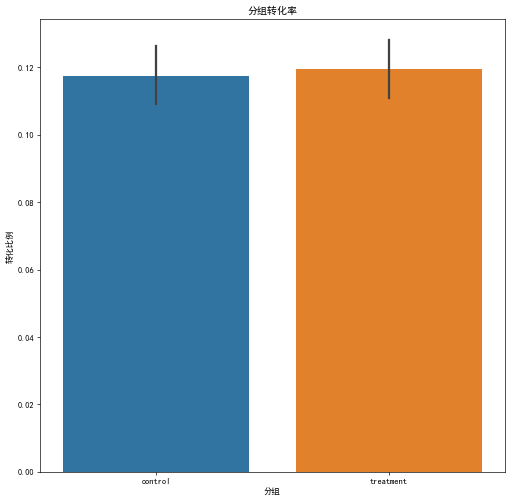

In [33]:
plt.rcParams['font.sans-serif']='SimHei'
plt.figure(figsize=(10,10),dpi=60)
sns.barplot(x=ab_test['group'],y=ab_test['converted'])
plt.title('分组转化率')
plt.xlabel('分组')
plt.ylabel('转化比例')
plt.show()

In [40]:
converted1=ab_test[ab_test['converted']==1]['group'].value_counts()/5000
converted1
# 根据上述结果可以看出新版本的转化率比老版本高了0.2%

treatment    0.1194
control      0.1174
Name: group, dtype: float64

假设检验
此案例样本量较大，使用Z检验

In [50]:
from statsmodels.stats.proportion import proportions_ztest,proportion_confint # 算Z值和置信区间

In [44]:
control_result=ab_test[ab_test['group']=='control']['converted']
treatment_result=ab_test[ab_test['group']=='treatment']['converted']

5000    1
5001    0
5002    0
5003    0
5004    0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: converted, Length: 5000, dtype: int64

In [56]:
n_con=control_result.count()
n_tre=treatment_result.count()
successes=[control_result.sum(),treatment_result.sum()] # 成功转化数量
nobs=[n_con,n_tre]
z_stat,pval=proportions_ztest(successes,nobs=nobs)
(lower_con,lower_treat),(upper_con,upper_treat)=proportion_confint(successes,nobs=nobs,alpha=0.05)

In [57]:
print(f'z statistic:{z_stat:.2f}')
print(f'p value:{pval:.3f}')
print(f'95% for control group:[{lower_con:.3f},{upper_con:.3f}]')
print(f'95% for treatment group:[{lower_treat:.3f},{upper_treat:.3f}]')

z statistic:-0.31
p value:0.757
95% for control group:[0.108,0.126]
95% for treatment group:[0.110,0.128]


分析结果及建议
由上述结果得到p值为0.757明显高于我们选用的α=0.05，故不能拒绝原假设，即新版本和旧版本没有明显不同
通过置信区间也可以看出treatment group的置信区间为[0.110,0.128]，根本没有达到预期的15%目标转化率
故新版本不是一个好的改进